In [22]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from run_permuted import PermutedMnistGenerator
from alg.cla_models_multihead import MFVI_NN, Vanilla_NN
from alg.IBP_BNN_multihead import IBP_BNN
from alg.utils import get_scores, concatenate_results
from alg.vcl import run_vcl
from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
hidden_size = [100]
batch_size = 128
no_epochs = 600
ANNEAL_RATE=0.000
MIN_TEMP=0.1

tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
data_gen = PermutedMnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
task_id=0

batch_size = 128
no_epochs = 200
ibp_samples = 10
alpha0 = 5.0
beta0 = 1.0
lambda_1 = 1.0
lambda_2 = 1.0
alpha = 4.0
K = 800
num_layers = 1
hidden_size = [K] * num_layers
run = 1
tag = "l1_mh_new"
alphas = []
# graph_ibp_perm_run4_l1_mh_new_task1
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()  
    x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    name = "ibp_{0}_run{1}_{2}_task{3}".format("perm", run + 1, tag, task_id + 1)

    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 1, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        stamp = {0: []*len(hidden_size)}
        ml_model.close_session()

    # Train on non-coreset data
    model = IBP_BNN(in_dim, hidden_size, out_dim, x_train.shape[0], 
                    num_ibp_samples=10, prev_means=mf_weights, 
                    prev_log_variances=mf_variances, prev_betas=mf_betas, alpha0=5.0, beta0=1.0,
                    learning_rate=0.0003, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100,
                    tensorboard_dir='../ddm/logs_perm', name=name)

    model.create_model()

    print("Restoring model: {}".format(model.log_folder))
    model.restore(model.log_folder)

    a = model.sess.run([tf.cast(tf.math.softplus(model.beta_a[i]) + 0.01, tf.float32) for i in range(model.no_layers-1)],
                            feed_dict={model.x: x_test, model.task_idx: task_id,
                                       model.training: False, model.finetune:False})
    alphas.append(a)
    model.close_session()
    
    

Epoch: 0001 cost= 0.233425458
Restoring model: ../ddm/logs_perm/graph_ibp_perm_run2_l1_mh_new_task1
Restoring model: ../ddm/logs_perm/graph_ibp_perm_run2_l1_mh_new_task2
Restoring model: ../ddm/logs_perm/graph_ibp_perm_run2_l1_mh_new_task3
Restoring model: ../ddm/logs_perm/graph_ibp_perm_run2_l1_mh_new_task4
Restoring model: ../ddm/logs_perm/graph_ibp_perm_run2_l1_mh_new_task5


In [11]:
alphas

[[array([9.279919 , 9.202303 , 9.167926 , 9.1633415, 9.041473 , 9.053713 ,
         8.990217 , 9.017016 , 8.992768 , 8.956953 , 8.917208 , 8.873777 ,
         8.913152 , 8.979564 , 8.961227 , 8.998182 , 8.981404 , 8.916576 ,
         8.944887 , 8.889452 , 8.843908 , 8.869001 , 8.837726 , 8.803162 ,
         8.625561 , 8.602807 , 8.7140255, 8.6843195, 8.193087 , 8.261341 ,
         8.021841 , 7.7264547, 7.498939 , 7.28754  , 6.940419 , 5.9549584,
         5.8236246, 5.5389266, 5.499098 , 5.457514 , 5.292615 , 4.780654 ,
         4.7039366, 4.2350307, 4.1242347, 4.151797 , 4.1013737, 4.2438912,
         4.418294 , 4.554981 , 4.6912045, 4.812532 , 4.9256134, 5.0026703,
         5.0917006, 5.1850133, 5.2482967, 5.3047795, 5.364971 , 5.4035096,
         5.4452763, 5.5096016, 5.537671 , 5.578806 , 5.621794 , 5.6328535,
         5.677568 , 5.675447 , 5.707126 , 5.7035146, 5.7479496, 5.757253 ,
         5.7784553, 5.8007617, 5.796065 , 5.7995524, 5.8140807, 5.836009 ,
         5.832055 , 5.845

In [15]:
len(alphas[0])

1

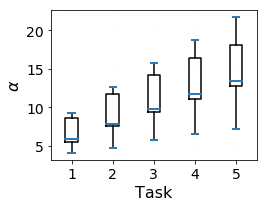

In [28]:
num_tasks = 5
grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 16
tick_size = 14
legend_size = 16

ticks = [str(i) for i in np.arange(5) + 1]
fig_size = (4, 3)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color='black', lw=1.5)
    plt.setp(bp['whiskers'], color='black', lw=1.5)
    plt.setp(bp['caps'], color=color, lw=2)
    plt.setp(bp['medians'], color=color, lw=2)

plt.figure(figsize=fig_size)
bpr = plt.boxplot([alphas[i][0][:100] for i in range(num_tasks)], positions=np.array(range(num_tasks)) * 2.0, sym='', widths=0.6)
set_box_color(bpr, '#2C7BB6')

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(-1, len(ticks) * 2 - 1)
plt.ylabel('$\\alpha$', fontsize=legend_size)
plt.xlabel('Task', fontsize=label_size)
plt.tight_layout()
plt.savefig('alphas_ibp.pdf', bbox_inches='tight')
plt.show()
